# Modeling


- You will find 4 different models below;
- Overall conclusions are placed in the end of this notebook as well.

In [1]:
# Imports
# Common imports
import sys
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# Utilites and Evaluation
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Linear model
from sklearn.linear_model import LinearRegression

# ARIMA model
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
import statsmodels.api as sm

# TBATS model
from tbats import TBATS

# PyTorch for my own model
import torch
import torch.nn as nn
import torch.optim as optim

# Models' IO
import pickle


In [2]:
# Custom import
# Add the chosen directory to the Python path
chosen_directory = '../src/'
sys.path.append(chosen_directory)

from utils import evaluate_errors, show_evaluation, define_split_points

## Load dataset

In [3]:
# Define the file path
raw_data_path = '../data/processed/daily_cp_activity_processed.csv'

# Load the dataset
df = pd.read_csv(raw_data_path)

## Data overview

In [5]:
# Data overview
df.head()

,Unnamed: 0,date,courier_partners_online,temperature,relative_humidity,precipitation,day_category,day_from_beginning
0,0,2021-05-01,49.0,0.589401,0.245614,0.0,0,0
1,1,2021-05-02,44.5,0.622992,0.210526,0.0,1,1
2,2,2021-05-03,40.0,0.560401,0.298246,0.0,1,2
3,3,2021-05-04,51.0,0.664719,0.175439,0.0,2,3
4,4,2021-05-05,50.0,0.648654,0.192982,0.0,2,4


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761 entries, 0 to 760
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               761 non-null    int64  
 1   date                     761 non-null    object 
 2   courier_partners_online  761 non-null    float64
 3   temperature              761 non-null    float64
 4   relative_humidity        761 non-null    float64
 5   precipitation            761 non-null    float64
 6   day_category             761 non-null    int64  
 7   day_from_beginning       761 non-null    int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 47.7+ KB


In [7]:
df.describe()

,Unnamed: 0,courier_partners_online,temperature,relative_humidity,precipitation,day_category,day_from_beginning
count,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000
mean,380.000000,64.720762,0.573221,0.391567,0.070788,1.001314,380.000000
std,219.826068,9.673105,0.207566,0.300970,0.135486,0.756549,219.826068
min,0.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,190.000000,58.000000,0.435427,0.157895,0.000000,0.000000,190.000000
50%,380.000000,66.000000,0.594409,0.280702,0.000000,1.000000,380.000000
75%,570.000000,72.000000,0.716670,0.631579,0.070543,2.000000,570.000000
max,760.000000,86.000000,1.000000,1.000000,1.000000,2.000000,760.000000


## Set up settings for plotting

In [51]:
# Set up colors for plotting
colors = [
    "#001F3F", "#0074E4", "#3498DB",  # Blue Shades
    "#006400", "#228B22", "#00FF00",  # Green Shades
    "#8B0000", "#B22222", "#CD5C5C",  # Red Shades
    "#800080", "#9370DB", "#E6E6FA",  # Purple Shades
    "#FF8C00", "#FF6347", "#FA8072",  # Orange Shades
    "#404040", "#808080", "#D3D3D3"   # Gray Shades
]

# Set the overall style and theme parameters
# sns.set_style("whitegrid")
# sns.set_style("whitegrid", rc={'grid.linestyle': '-', 
#                                'grid.color': 'lightgray',
#                                'grid.alpha': 0.5})

# Set fonts
font_12 = FontProperties(family="Helvetica Neue", size=12)
font_16 = FontProperties(family="Helvetica Neue", size=16)

## 1. Linear Regression models

Given the linear model and the potential changes in trends over time, adopting the following approach would be prudent. Specifically, if '---' represents the training batch and '^^^' signifies the test batch, the learning process unfolds as follows:

1. [&emsp; .&emsp; .--- | ^^^]
2. [&emsp; .---.--- | ^^^ ]
3. [---.---.--- | ^^^ ]

The test dataset is always the most recent time series, because here I'm interested in forecasting rather than retrospecting or random train/test split.

I couldn't find the proper function for this, hence I made this by my own.

In [9]:
def linear_regression(df, tr_begin, tr_fin, verbosity=1):
    """
    Fit the linear regression function with specific train dataset parameters.

    Parameters:
    - df (pd.DataFrame): dataframe
    - tr_begin (int): index for beginning of train dataset
    - tr_fin (int): index for end of train dataset (and beginning of test dataset)
    - verbosity: 0, 1 or 2. 

    Returns:
    - model: Regression model
    """
    # Split the data into features (X) and target variable (y)
    X_train = df[['temperature', 'precipitation', 'day_category', 'day_from_beginning']][tr_begin:tr_fin]
    y_train = df['courier_partners_online'][tr_begin:tr_fin]
    X_test = df[['temperature', 'precipitation', 'day_category', 'day_from_beginning']][tr_fin:]
    y_test = df['courier_partners_online'][tr_fin:]

    # Initialize the linear regression model
    model = LinearRegression()

    # Train the model on the training set
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model using metrics such as Mean Absolute Error (MAE), Mean Squared Error (MSE), and R-squared
    mse, mae, r2 = evaluate_errors(y_test, y_pred)
    
    # Verbosity levels:
    if verbosity >= 1:
        print(f'Train size is {tr_fin - tr_begin} days, Test size is {len(df) - tr_fin} days')
        print(f'Mean Squared Error (MSE): {round(mse, 2)}')
    if verbosity >= 2:
        print(f'Mean Absolute Error (MAE): {round(mae, 2)}')
        print(f'R-squared (R2): {round(r2, 2)}')
    if verbosity:
        print('')

    return model


In [10]:
# Make predictions for the last 30 days

# Define and show the split indexes
tr_fin, tr_begin_list = define_split_points(df, 30)
print('End index for train dataset:', tr_fin)
print('Start indexes for train dataset:', tr_begin_list)

End index for train dataset: 731
Start indexes for train dataset: [701, 671, 641, 611, 581, 551, 521, 491, 461, 431, 401, 371, 341, 311, 281, 251, 221, 191, 161, 131, 101, 71, 41, 11, 0]


In [11]:
# Container for models:
linear_models = []

# Index counter to find the right model in the list easier
i = 0

# Searching for a suitable train set
for tr_begin in tr_begin_list:
    print(f'Linear model {i}:')
    model = linear_regression(df=df, tr_begin=tr_begin, tr_fin=tr_fin, verbosity=1)
    linear_models.append(model)
    i += 1

Linear model 0:
Train size is 30 days, Test size is 30 days
Mean Squared Error (MSE): 7.46

Linear model 1:
Train size is 60 days, Test size is 30 days
Mean Squared Error (MSE): 10.59

Linear model 2:
Train size is 90 days, Test size is 30 days
Mean Squared Error (MSE): 8.67

Linear model 3:
Train size is 120 days, Test size is 30 days
Mean Squared Error (MSE): 7.5

Linear model 4:
Train size is 150 days, Test size is 30 days
Mean Squared Error (MSE): 4.56

Linear model 5:
Train size is 180 days, Test size is 30 days
Mean Squared Error (MSE): 4.94

Linear model 6:
Train size is 210 days, Test size is 30 days
Mean Squared Error (MSE): 5.72

Linear model 7:
Train size is 240 days, Test size is 30 days
Mean Squared Error (MSE): 5.78

Linear model 8:
Train size is 270 days, Test size is 30 days
Mean Squared Error (MSE): 5.67

Linear model 9:
Train size is 300 days, Test size is 30 days
Mean Squared Error (MSE): 5.57

Linear model 10:
Train size is 330 days, Test size is 30 days
Mean Square

As we can see, the best performance is for model #4.

From 480+ days backwards as a train set results begin noticebly worsen. I suppose it happens because in this point some bigger trend(s) change(s).

Well, let's observe results and save the model.

In [12]:
# Pick the best model
best_linear_model = linear_models[4]
best_linear_model

LinearRegression()

MSE: 4.56
MAE: 1.68
R2: 0.7

MAE if compared to the average line: 3.31
MSE if compared to the average line: 15.31


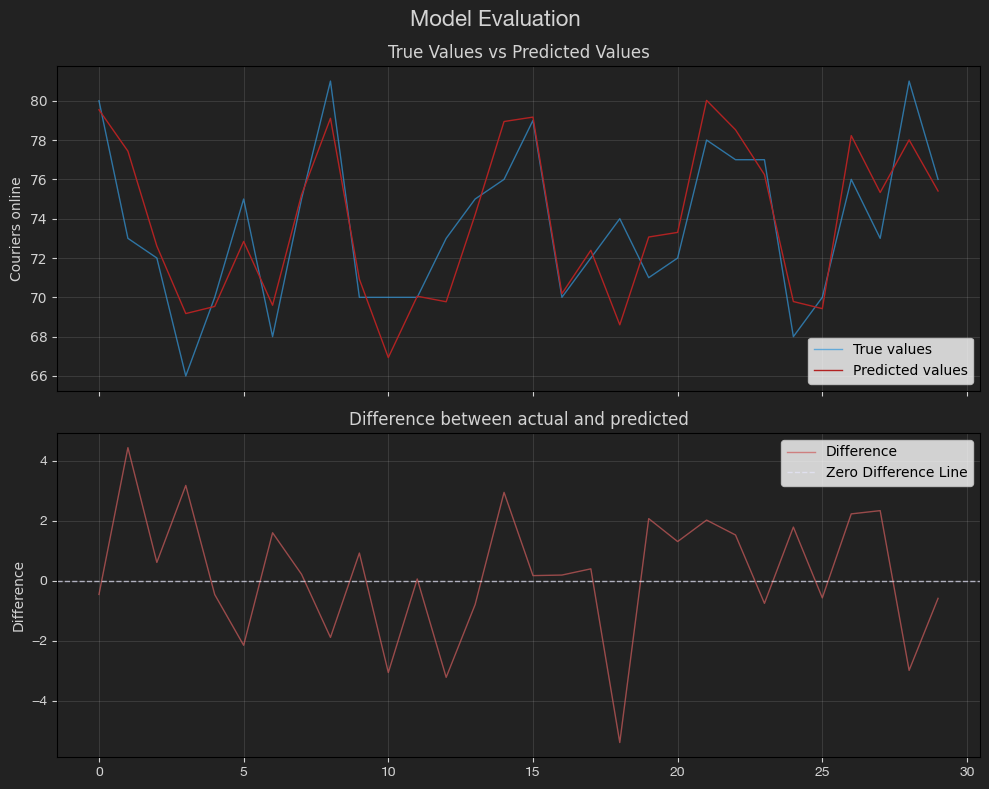

In [15]:
# Define X_test, y_test
X_test = df[['temperature', 'precipitation', 'day_category', 'day_from_beginning']][tr_fin:]
y_test = df['courier_partners_online'][tr_fin:]

# Predict values with the best model
y_pred = best_linear_model.predict(X_test)

# Evaluate with a few metrics:
mse, mae, r2 = evaluate_errors(y_test=y_test, y_pred=y_pred)
print(f'MSE: {round(mse,2)}\nMAE: {round(mae,2)}\nR2: {round(r2,2)}\n')

# Comparison with the average line
mae_avg_line = abs(y_test.mean() - y_test).mean()
mse_avg_line = abs((y_test.mean() - y_test)**2).mean()
print(f'MAE if compared to the average line: {round(mae_avg_line, 2)}')
print(f'MSE if compared to the average line: {round(mse_avg_line, 2)}')

# Show graphs
show_evaluation(y_test=y_test, y_pred=y_pred)

In [16]:
# Save the trained model to a file using pickle
with open('../models/linear_model.pkl', 'wb') as file:
    pickle.dump(best_linear_model, file)

**Usage and restrictions:**
- This model relies on weather condition data, i.e. on how well meteorologists managed to predict it. It decreases this model accuracy.
- It could be useful to **predict** amount of couriers online in **short future period**.

**Evaluations**
- Mean Absolute Error 2 times less, than if predict with the average line.
- Prediction curve quite close repeat the original one's shape visually
- MAE is 1.68, MSE is 4.56 with average line 73.6 and amplitude about ±6. 

**Strengths**
- Simplicity
- Easy to tune for the specific time period which better represents the last trends

**Weaknesses**
- It depends on weather forecast

## 2. SARIMA model

### Data preparation

In [17]:
# Create the distinct DataFrame with only variable and date as index
df_date = df[['date', 'courier_partners_online']].copy()
df_date['date'] = pd.to_datetime(df_date['date'])
df_date.set_index('date')
df_date.head()

,date,courier_partners_online
0,2021-05-01,49.0
1,2021-05-02,44.5
2,2021-05-03,40.0
3,2021-05-04,51.0
4,2021-05-05,50.0


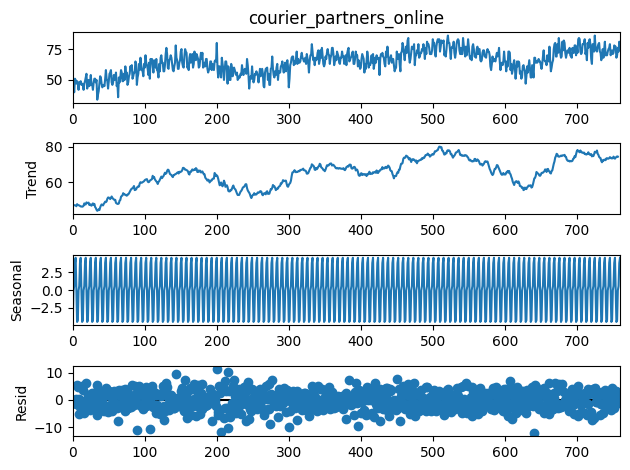

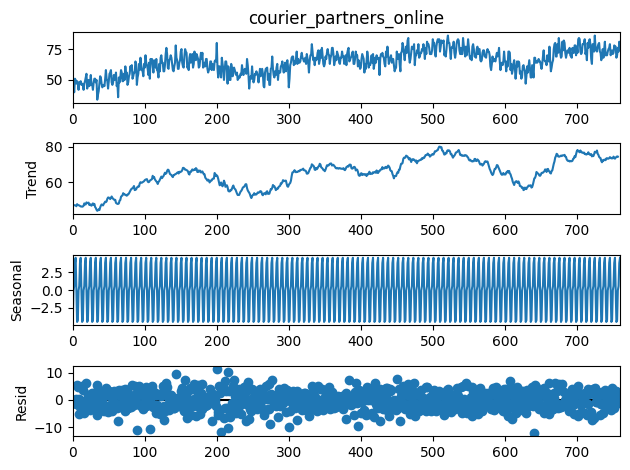

In [26]:
seasonal_period=7
result = seasonal_decompose(df_date['courier_partners_online'], period=seasonal_period)
result.plot()

- There is relatively big rabge of residual, not so good

In [32]:
# Looking for the best parameters for SARIMA
# I take only the last few periods, because this model can't be used for long predictions
model_arima = auto_arima(df_date['courier_partners_online'][-56:-14], 
           seasonal=True, 
           m=7, 
           trace=True, 
           suppress_warnings=True, 
           error_action='ignore', 
           stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=256.546, Time=0.47 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=260.884, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=254.807, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=257.944, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=483.925, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=260.314, Time=0.01 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=256.100, Time=0.20 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=268.726, Time=0.10 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=257.967, Time=0.05 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=258.229, Time=0.23 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=253.161, Time=0.10 sec
 ARIMA(0,0,0)(2,0,0)[7] intercept   : AIC=252.391, Time=0.16 sec
 ARIMA(0,0,0)(2,0,1)[7] intercept   : AIC=255.726, Time=0.11 sec
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=254.286, Time=0.08 sec
 ARIMA(0,0,1)(2,0,0)[7] intercept   : AIC=263.9

In [33]:
# SARIMA order parameters (p, d, q) x (P, D, Q, s)
order = (0, 0, 0) 
seasonal_order = (2, 0, 0, 7) 

sarima_model = sm.tsa.statespace.SARIMAX(df['courier_partners_online'][-56:-14],
                         order=order,
                         seasonal_order=seasonal_order,
                         )

sarima_results = sarima_model.fit(disp=False)

In [35]:
# Make predictions
forecast_steps = 28  # Specify the number of steps to forecast
forecast = sarima_results.get_forecast(steps=forecast_steps)

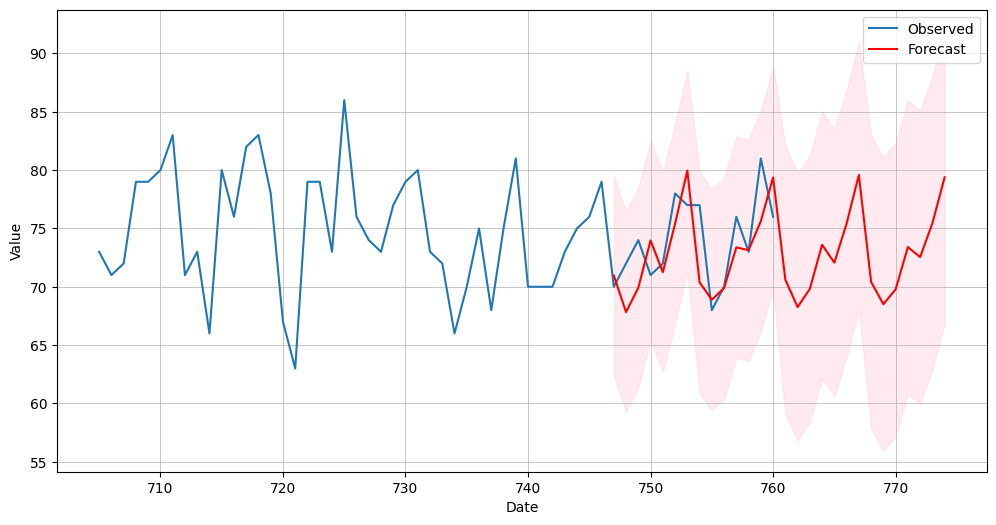

In [36]:
# Plot the results
ax = df_date['courier_partners_online'][-56:].plot(label='Observed', figsize=(12, 6))
forecast.predicted_mean.plot(ax=ax, label='Forecast', color='red')

# Plot confidence intervals if available
confidence_intervals = forecast.conf_int()
ax.fill_between(confidence_intervals.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)

ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.legend()

plt.grid(linewidth=0.5)
plt.show()

In [39]:
# Evaluate with a few metrics:
mse, mae, r2 = evaluate_errors(y_pred=forecast.predicted_mean[:14], y_test=df['courier_partners_online'][-14:])
print(f'MSE: {round(mse,2)}\nMAE: {round(mae,2)}\nR2: {round(r2,2)}\n')

MSE: 10.83
MAE: 2.69
R2: 0.14



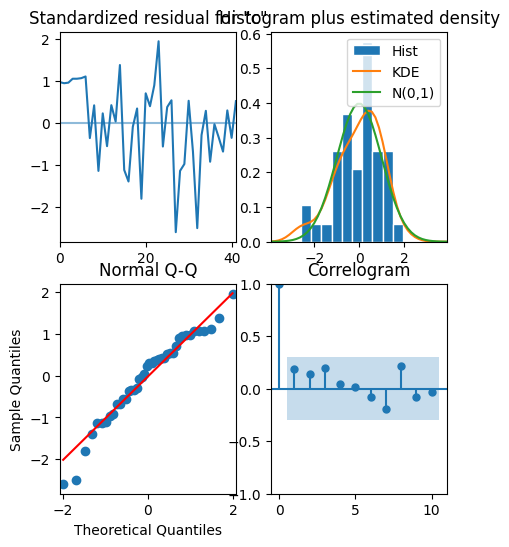

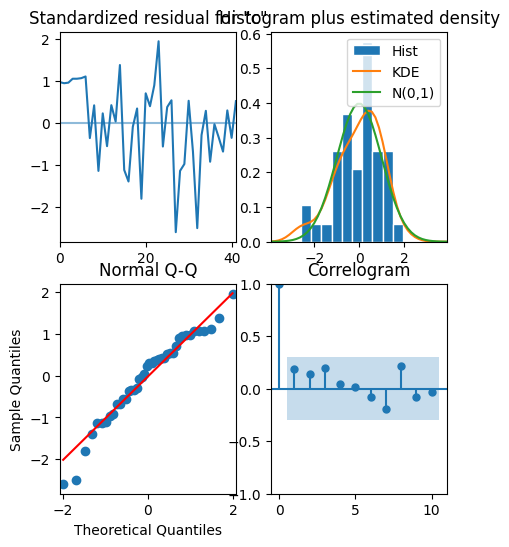

In [43]:
sarima_results.plot_diagnostics(figsize=(5,6))

Conclusions:

- This model could be useful for short term predictions only, because data has bigger seasonality, that is not suitable for this kind of model

## 3. TBATS Model

This model must perfectly fit for this dataset, because it is designed especially for multi-seasonality.

### Data preparation

In [44]:
# Create the distinct DataFrame with only variable and date as index
df_date = df[['date', 'courier_partners_online']].copy()
df_date['date'] = pd.to_datetime(df_date['date'])
df_date.set_index('date')
df_date.head()

,date,courier_partners_online
0,2021-05-01,49.0
1,2021-05-02,44.5
2,2021-05-03,40.0
3,2021-05-04,51.0
4,2021-05-05,50.0


In [45]:
# Normalize the variable for better performance
scaler = MinMaxScaler()
scaler.fit(df_date[['courier_partners_online']])
scaled_data = scaler.transform(df_date[['courier_partners_online']])

### 3-seasonal model

In [56]:
# Fit TBATS model for the last 2 years
tbats_model = TBATS(seasonal_periods=(7, 183, 365), use_trend=True)
tbats_fit = tbats_model.fit(scaled_data[-730:])

In [57]:
print(f'AIC score is {round(tbats_fit2.aic, 1)}')

AIC score is 1105.5


In [60]:
# Forecast future values
forecast = tbats_fit.forecast(steps=365)

# Place predicted values to the right place
y_pred = scaler.inverse_transform(forecast.reshape(-1, 1)).squeeze()
y_pred = np.concatenate((np.full(len(df_date), np.nan), y_pred), axis=0)

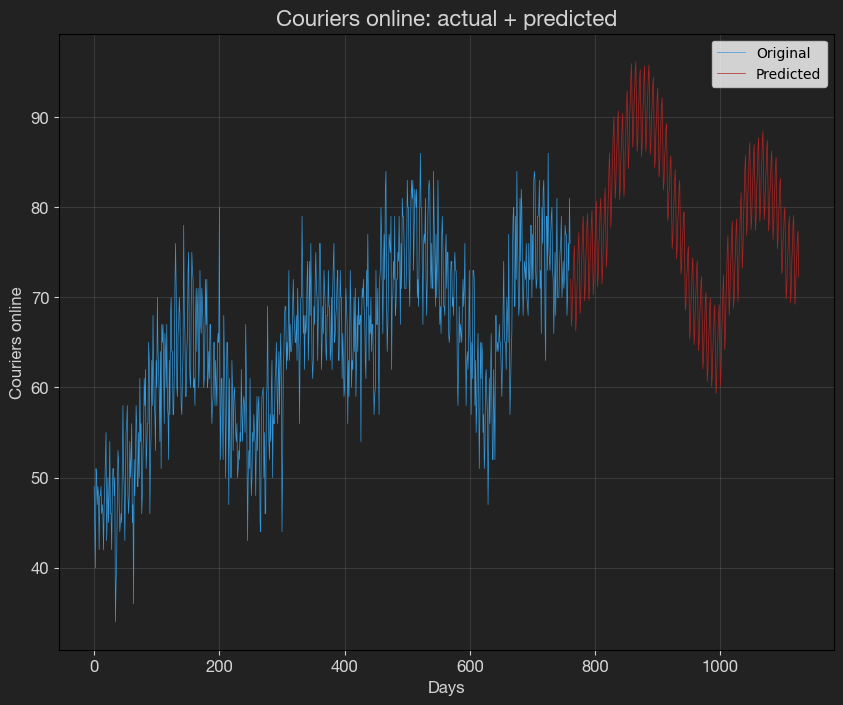

In [69]:
# Set up subplots
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8), sharex=True)

ax.grid(linewidth=0.5, color='lightgray', alpha=0.2)
ax.plot(df_date['courier_partners_online'], color=colors[2], linewidth=0.5, label='Original')
ax.plot(y_pred, color=colors[7], linewidth=0.5, label='Predicted', alpha=1)

# Fonts
font_12 = FontProperties(family="Helvetica Neue", size=12)
font_16 = FontProperties(family="Helvetica Neue", size=16)

# Adjust layout
fig.set_facecolor('#222222')
ax.set_facecolor('#222222')
ax.tick_params(colors='lightgray')
plt.legend()
plt.xlabel('Days', color='lightgray', fontproperties=font_12)
plt.ylabel('Couriers online', color='lightgray', fontproperties=font_12)
plt.title('Couriers online: actual + predicted', color='lightgray', fontproperties=font_16)
plt.xticks(fontproperties=font_12)
plt.yticks(fontproperties=font_12)

plt.show()

MSE: 8.8
MAE: 2.39
R2: 0.44



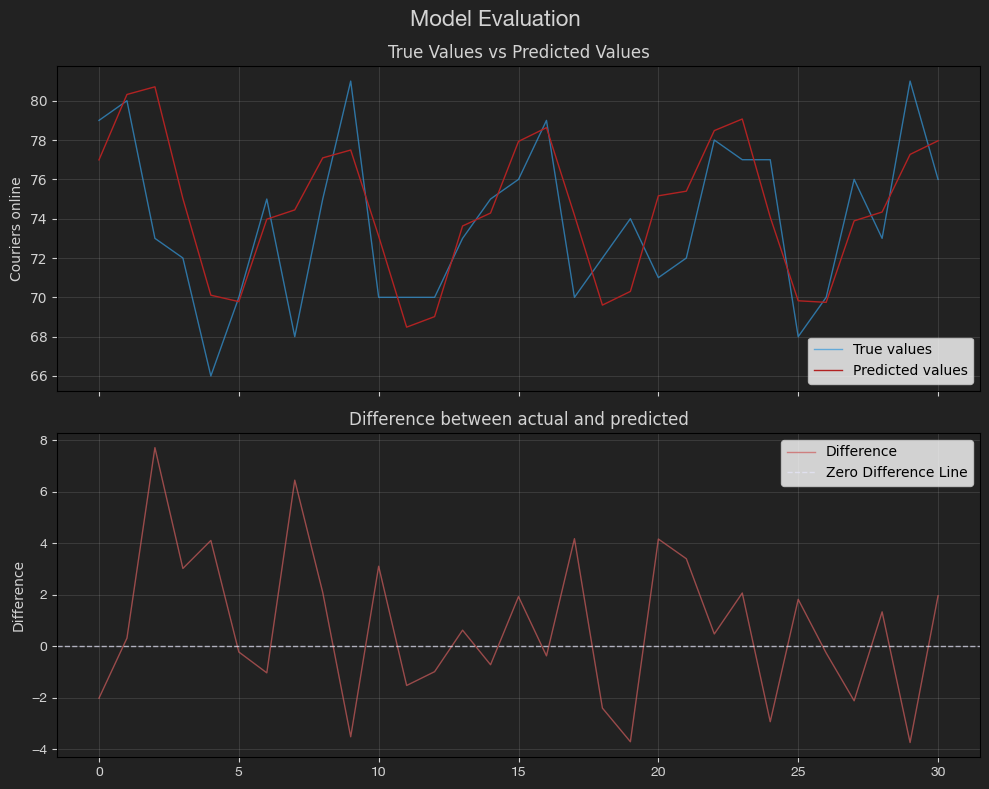

In [70]:
y_ = scaler.inverse_transform(tbats_fit2.y.reshape(-1, 1)).squeeze()[-31:]
y_hat = scaler.inverse_transform(tbats_fit2.y_hat.reshape(-1, 1)).squeeze()[-31:]

# Evaluate with a few metrics:
mse, mae, r2 = evaluate_errors(y_test=y_, y_pred=y_hat)
print(f'MSE: {round(mse,2)}\nMAE: {round(mae,2)}\nR2: {round(r2,2)}\n')

show_evaluation(y_, y_hat)

In [71]:
# Save the trained model to a file using pickle
with open('../models/tbats_model.pkl', 'wb') as file:
    pickle.dump(tbats_fit2, file)

Conclusions:

- Very good model for making predictions of any term!
- The only bad here is complexity.

## 4. My own model

### Equation

$$y=I + Sx + \sum_{i=1}^{3} A_i sin(2\pi F_i x + P_i))$$

Here, $y$ is couriers online, $x$ is the day index, $I$ is Intercept, $S$ is Slope, three sines describe 1 year, 1/2 year and 1 week oscilations with $A_i$ - Amplitudes, $F_i$ - Frequencies and $P_i$ - Phase shifts.

### Define and train PyTorch model

In [72]:
# Step 1: Define initial parameters
slope = 0.0
intercept = df['courier_partners_online'].mean()
amplitudes = [df['courier_partners_online'].std() for i in range(3)]
frequencies = [1/7, 1/182.625, 1/365.25]
phases = [0, 0, 0]

# Step 2: Load Data
X = torch.Tensor(df['day_from_beginning'][-730:].to_numpy())
y = torch.Tensor(df['courier_partners_online'][-730:].to_numpy())

# Step 3: Create a PyTorch Model
class SinusoidModel(nn.Module):
    def __init__(self, slope, intercept, amplitudes, frequencies, phases):
        super(SinusoidModel, self).__init__()
        self.slope = nn.Parameter(torch.Tensor([slope]))
        self.intercept = nn.Parameter(torch.Tensor([intercept]))
        self.amplitudes = nn.Parameter(torch.Tensor(amplitudes))
        self.frequencies = nn.Parameter(torch.Tensor(frequencies))
        self.phases = nn.Parameter(torch.Tensor(phases))
        
    def equation(self, x, slope, intercept, amplitudes, frequencies, phases):
        line = slope * x + intercept
        sinusoids = sum(a * torch.sin(2 * torch.pi * f * x + p) for a, f, p in zip(amplitudes, frequencies, phases))
        return line + sinusoids
        
    def forward(self, x):
        y = self.equation(x, model.slope, model.intercept, model.amplitudes, model.frequencies, model.phases)
        return y

# Create an instance of the model
model = SinusoidModel(slope, intercept, amplitudes, frequencies, phases)

# Step 4: Loss Function
criterion = nn.MSELoss()

# Set optimizer
optimizer = optim.Adam([model.phases, model.amplitudes, model.intercept, model.slope], lr=0.01)


In [73]:
# Step 5: Define the training cycle
# Set dict for training log
training_log = {'Epoch':[], 'MSELoss':[]}

# Set training cycle
num_epochs = 3000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    if not epoch % 100:
        training_log['Epoch'].append(epoch)
        training_log['MSELoss'].append(loss.tolist())
        print('*', end='')
print('Done')


******************************Done


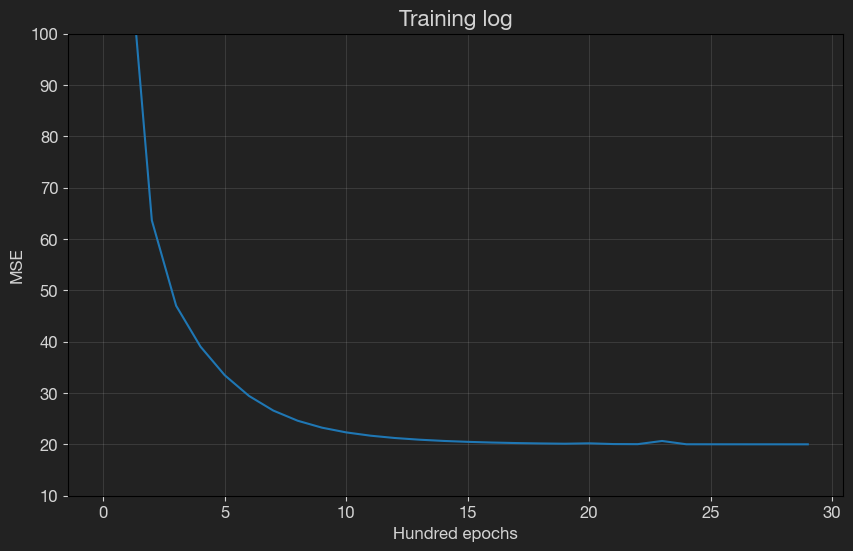

In [74]:
# Set up subplots
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), sharex=True)

ax.grid(linewidth=0.5, color='lightgray', alpha=0.2)
ax.plot(training_log['MSELoss'])

# Fonts
font_12 = FontProperties(family="Helvetica Neue", size=12)
font_16 = FontProperties(family="Helvetica Neue", size=16)

ax.set_facecolor('#222222')
fig.set_facecolor('#222222')
ax.tick_params(colors='lightgray')
plt.xlabel('Hundred epochs', color='lightgray', fontproperties=font_12)
plt.ylabel('MSE', color='lightgray', fontproperties=font_12)
plt.title('Training log', color='lightgray', fontproperties=font_16)
plt.xticks(fontproperties=font_12)
plt.yticks(fontproperties=font_12)
plt.ylim([10, 100])

plt.show()

### Validation and predictions

MSE: 14.170000076293945
MAE: 2.940000057220459
R2: 0.1



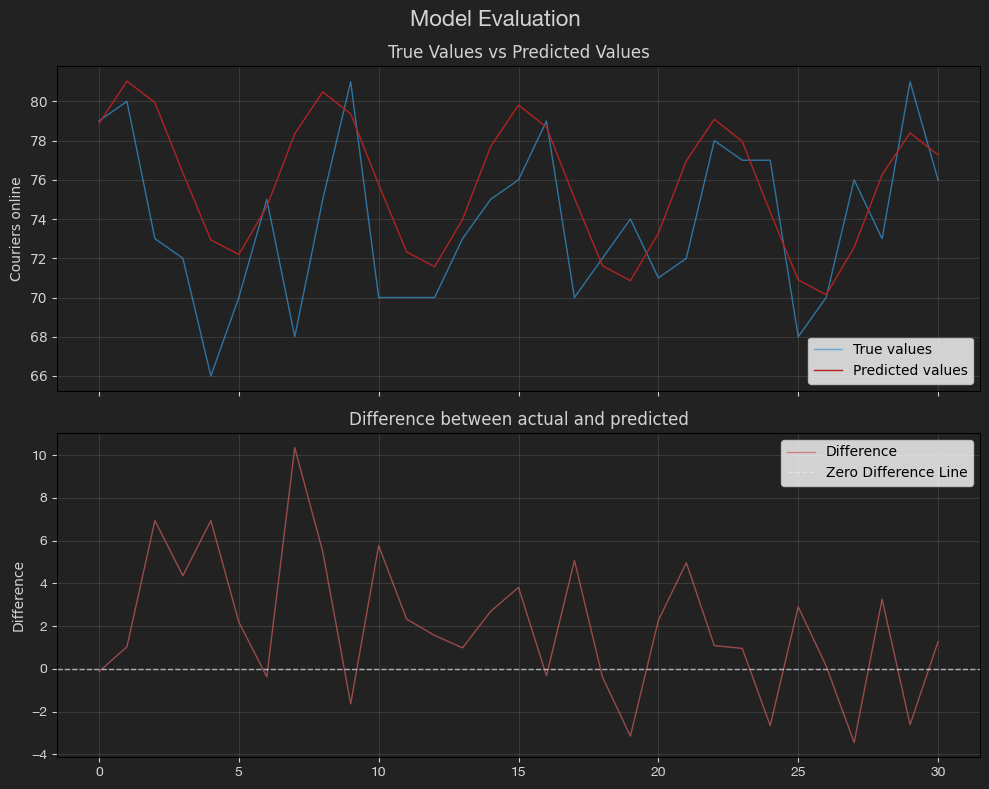

In [75]:
# Step 6: Validation on the last month
with torch.no_grad():
    y_pred = model(X[-31:])

y_last_month = y[-31:]

# Evaluate with a few metrics:
mse, mae, r2 = evaluate_errors(y_test=y_last_month, y_pred=y_pred)
print(f'MSE: {round(mse, 2)}\nMAE: {round(mae,2)}\nR2: {round(r2,2)}\n')

show_evaluation(y_last_month, y_pred)

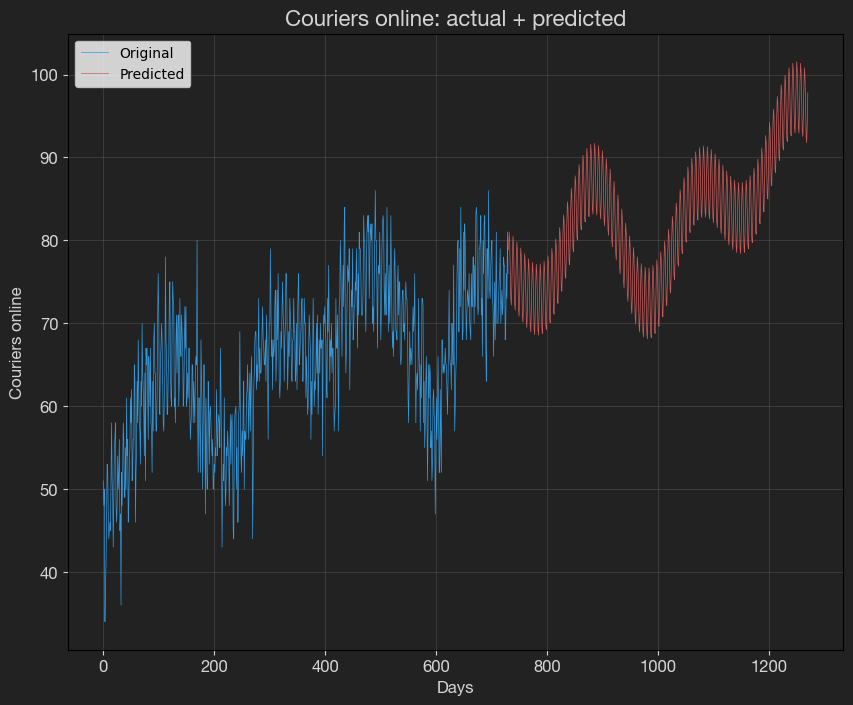

In [78]:
# Step 7: Use the trained model to make predictions

days_to_predict = 540
days_to_predict_range = torch.Tensor([len(X)+i for i in range(days_to_predict)])

with torch.no_grad():
    prediction = model(days_to_predict_range)
    
y_pred = pd.Series(prediction, index=days_to_predict_range.tolist())
y = y

# Set up subplots
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8), sharex=True)

# Plot the results
ax.plot(y, color=colors[2], linewidth=0.5, label='Original')
ax.plot(y_pred, color=colors[8], linewidth=0.5, label='Predicted', alpha=1)

# Adjust layout
ax.grid(linewidth=0.5, color='lightgray', alpha=0.2)
ax.set_facecolor('#222222')
ax.tick_params(colors='lightgray')
fig.set_facecolor('#222222')
plt.legend()
plt.xlabel('Days', color='lightgray', fontproperties=font_12)
plt.ylabel('Couriers online', color='lightgray', fontproperties=font_12)
plt.title('Couriers online: actual + predicted', color='lightgray', fontproperties=font_16)
plt.xticks(fontproperties=font_12)
plt.yticks(fontproperties=font_12)
plt.show()

In [149]:
# Step 8: Save the model
torch.save(model, '../models/own_pytorch_model.pth')

- This model looks worse, then TBATS, I guess because it is easier and has less parameters. Nevertheless, it's still repeating well the original trends and could be useful for forecasting as well.
- The main strength of this model - it could be tuned simply for another time period or with additional parameters and it's light-weighted.

---

## Overall conclusions:

### Performance

- The best performance is shown by Linear regression model. The only problem is we have to know the weather.

- For unknown weather TBATS model has the best performance for both short and long term forecasting.

### Complexity

- The most complex model is TBATS, where PyTorch and Linear models are the easiest.

### Applicability

- To know the amount of Couriers online could be pretty useful for any planning for money, logistic, time of orders delivery and so on. These models **decrease the uncertainty** meaningfully and make expectations more reliable.

- If the data from another places have the same patterns - these models can be ported broadly.

### Further development

- Any model should be checked and updated from time to time to follow the recent trends. At the same time data for the bigger period must be studied to check some overseasonal (long) patterns.

- For evaluation I see 2 different approaches:
    - Visual observation: How close the prediction curve to the actual one? How well it follows the trends?
    - Comparison of MAE and MSE of model prediction and of just average line of the period. How many times is the model better than just average line? (for short term prediction)
    
- I would try to add additional parameters to equation in PyTorch model to make better the most simple model. To keep it the most clear model and save computational resourses.

